# Estimating Causal Effect towards individual Resilience to risks globally
Code authored by: Minh Kieu, UoA, 2023 <br />
DoWhy Library: https://microsoft.github.io/dowhy/ <br />
Data from: https://wrp.lrfoundation.org.uk


### Import libraries

In [39]:
#data modules
import pandas as pd 
import pickle
import pyreadstat

#Causal Discover modules
from pgmpy.estimators import HillClimbSearch, BicScore
import networkx as nx
import matplotlib.pyplot as plt

#Causal Inference modules
from sklearn.ensemble import RandomForestRegressor
import econml
import dowhy
from dowhy import CausalModel

### Load data


In [40]:
df, meta = pyreadstat.read_sav("../Data/lrf_wrp_2021_full_data.sav")
#filter out countries with number of data points less than 1200
df = df.groupby('Country').filter(lambda x: x['Country'].count() >= 1200)
df_1=df[df['Q1'].isnull()]

df.head(2)

,WPID_RANDOM,WP5,Country,WGT,Year,GlobalRegion,country.in.both.waves,CountryIncomeLevel2021,CountryIncomeLevel2019,PROJWT_2021,...,REGION_ZAF,REGION2_ZMB,REGION_ZWE,Q2_1_2019A,Q2_1_2019B,Q5A_2019,Q5B_2019,Q5C_2019,Q5D_2019,Q5F_2019
0,174262180.0,1.0,United States,2.132627,2021.0,6.0,1.0,4.0,NaN,562058.627707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,115327451.0,1.0,United States,0.620385,2021.0,6.0,1.0,4.0,NaN,163503.920074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 1: Estimate the values of Perception, Experience and Resilience index

#### For given risk (eg: crime)
$$\text{Perception Index (given country)} = \text{avg of individual perception scores of a country}$$
$$\text{Experience Index (given country)} = \text{avg of individual experience scores of a country}$$
$$\text{Risk Impact Index (individual)} = \text{experience score} \times \text{perception score}$$


#### Resilience index for all seven risks
$$\text{Resilience Index (individual)} = \text{Average of all the individual response to Resilience-related questions} $$

- To calculate the perception score, the weitages are  very worried = 1, somewhat worried = 0.5, not worried = 0, and DK & refused = missing 

- To calculate the experience score, the weitages are  Both = 1, Yes,personally experienced = 0.75, Yes,know someone who has experienced = 0.5, No = 0, and DK & refused = missing 

### Step 1.1: First, let's estimate the Perception, Experience and Risk Impact Index

In [41]:
import numpy as np 

perception_df=df[['GlobalRegion','Country', 'Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G','Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']].copy()

# Replace Don't know and Refuse to answer response to NaN
cols_to_replace = ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G','Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']
replace_dict = {98: np.nan, 99: np.nan}
perception_df[cols_to_replace] = perception_df[cols_to_replace].replace(replace_dict)

#removing the raws if all the columns have missing values, 98, 99 
perception_df.dropna(subset=['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G','Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G'], thresh=7, inplace=True)

# replace the values 2 with 0.5 and 3 with 0
perception_df.loc[:, ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G']] = perception_df.loc[:, ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G']].replace({2: 0.5, 3: 0})
perception_df.loc[:, ['Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']] = perception_df.loc[:, ['Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']].replace({3: 1, 1: 0.75, 2: 0.5, 4: 0})

# define a function to compute the average of the non-ignored values in each row for perception score (worry) and experience score)
def compute_average(row):
    valid_values = [value for value in row if not pd.isna(value)]
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return np.nan

# create a new column with the computed average
perception_df['Perception_index'] = perception_df.loc[:, ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G']].apply(compute_average, axis=1)
perception_df['Experience_index'] = perception_df.loc[:, ['Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']].apply(compute_average, axis=1)
perception_df['Impact_index'] = perception_df['Perception_index'] * perception_df['Experience_index']
perception_df.head(2)


,GlobalRegion,Country,Q4A,Q4B,Q4C,Q4D,Q4E,Q4F,Q4G,Q5A,Q5B,Q5C,Q5D,Q5E,Q5F,Q5G,Perception_index,Experience_index,Impact_index
0,6.0,United States,1.0,1.0,1.0,1.0,0.5,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.750000,0.0,0.0
1,6.0,United States,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214286,0.0,0.0


Now we can drop the individual questions related to Perception and Experience 

In [42]:
df= df.drop(cols_to_replace, axis=1)
df = df.join(perception_df[['Perception_index','Experience_index','Impact_index']])
df.head(2)

,WPID_RANDOM,WP5,Country,WGT,Year,GlobalRegion,country.in.both.waves,CountryIncomeLevel2021,CountryIncomeLevel2019,PROJWT_2021,...,Q2_1_2019A,Q2_1_2019B,Q5A_2019,Q5B_2019,Q5C_2019,Q5D_2019,Q5F_2019,Perception_index,Experience_index,Impact_index
0,174262180.0,1.0,United States,2.132627,2021.0,6.0,1.0,4.0,NaN,562058.627707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,0.0,0.0
1,115327451.0,1.0,United States,0.620385,2021.0,6.0,1.0,4.0,NaN,163503.920074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,0.0,0.0


In [45]:
df2 = df.drop(df.iloc[:, 68:194],axis = 1)
cols_to_remove = ['WPID_RANDOM','WP5','WGT','Year','country.in.both.waves','CountryIncomeLevel2021','CountryIncomeLevel2019','PROJWT_2021','PROJWT_2019','AgeGroups4','HouseholdSize','Q2_1','Q3','Q6','Q7A','Q7C','resilience_index','Worried.Index','Experienced.Index','worry_exp_gap']
df2 = df2.drop(cols_to_remove,axis=1)
df2.head(2)

,Country,GlobalRegion,Age,Gender,Education,IncomeFeelings,INCOME_5,EMP_2010,Urbanicity,ChildrenInHousehold,...,Q22D,Q22E,Q23A,Q23B,Q23C,Q23D,Q23E,Perception_index,Experience_index,Impact_index
0,United States,6.0,70.0,1.0,1.0,2.0,2.0,6.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.750000,0.0,0.0
1,United States,6.0,56.0,1.0,3.0,1.0,5.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.214286,0.0,0.0


### Step 1.2: Now let' estimate the value of Resilience index

In [46]:
index_resi=df[['GlobalRegion','Country', 'Q20', 'Q21','Q10Q11Recode','Q16C', 'Q13','Q16D','Q16A','Q16B']].copy()

# replace DOn't know and Refuse to answer to NaN
cols_to_replace = ['Q20', 'Q21','Q10Q11Recode','Q16C', 'Q13','Q16D','Q16A','Q16B']
replace_dict = {98: np.nan, 99: np.nan}
index_resi[cols_to_replace] = index_resi[cols_to_replace].replace(replace_dict)


# replace the values 2 with 0.5 and 3 with 0
index_resi.loc[:, ['Q13']] = index_resi.loc[:, ['Q13']].replace({2: 0.5, 3: 0})
index_resi.loc[:, ['Q10Q11Recode']] = index_resi.loc[:, ['Q10Q11Recode']].replace({1: 0.1, 2: 0.2, 3: 0.3, 4: 0.4, 5: 0.5, 6: 0.8, 7: 0.9, 8: 1, 9: 0.7})
index_resi.loc[:, ['Q20','Q16D','Q16A','Q16B','Q16C']] = index_resi.loc[:, ['Q20','Q16D','Q16A','Q16B','Q16C']].replace({3: 0.5, 2: 0})
index_resi.loc[:, ['Q21']] = index_resi.loc[:, ['Q21']].replace({2: 0})

# define a function to compute the average of the non-ignored values in each row for perception score (worry) and experience score)
def compute_average(row):
    valid_values = [value for value in row if not pd.isna(value)]
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return np.nan

# create a new column with the computed average
# index['individual_score'] = index.loc[:, []].apply(compute_average, axis=1)
#index_resi['household_score'] = index_resi.loc[:, ['Q21','Q10Q11Recode','Q16C']].apply(compute_average, axis=1)
#index_resi['community_score'] = index_resi.loc[:, ['Q13', 'Q16D']].apply(compute_average, axis=1)
#index_resi['society_score'] = index_resi.loc[:, ['Q16A','Q16B']].apply(compute_average, axis=1)

# Calculating individual resilience score
index_resi['Resilience_index'] = index_resi.loc[:, cols_to_replace].apply(compute_average, axis=1)
index_resi.head(2)

,GlobalRegion,Country,Q20,Q21,Q10Q11Recode,Q16C,Q13,Q16D,Q16A,Q16B,Resilience_index
0,6.0,United States,1.0,1.0,0.8,1.0,1.0,0.0,0.0,1.0,0.725
1,6.0,United States,1.0,1.0,0.8,1.0,1.0,1.0,0.0,1.0,0.850


In [47]:

df2= df2.drop(cols_to_replace, axis=1)
df2 = df2.join(index_resi[['Resilience_index']])
df2.head(2)


,Country,GlobalRegion,Age,Gender,Education,IncomeFeelings,INCOME_5,EMP_2010,Urbanicity,ChildrenInHousehold,...,Q22E,Q23A,Q23B,Q23C,Q23D,Q23E,Perception_index,Experience_index,Impact_index,Resilience_index
0,United States,6.0,70.0,1.0,1.0,2.0,2.0,6.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.750000,0.0,0.0,0.725
1,United States,6.0,56.0,1.0,3.0,1.0,5.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.214286,0.0,0.0,0.850


## Step 2: Perform Causal Discovery using a Bayesian Network

Bayesian networks (BNs) can be used for causal discovery from observational data. In fact, they are one of the primary tools for this task.

A Bayesian network is a directed acyclic graph (DAG) that represents the joint probability distribution over a set of variables. Each node in the graph corresponds to a variable, and the edges between the nodes represent probabilistic dependencies between the variables.

In the context of causal discovery, the variables are random variables that represent possible causes and effects, and the edges in the graph represent causal relationships. When we have observational data over these variables, we can learn the structure of the BN -- i.e., we can perform causal discovery.

The learning process is usually divided into two steps:

- Structure learning: Given the data, learn the underlying DAG that represents the data. The most common methods for structure learning are constraint-based methods, score-based methods, and hybrid methods.

- Parameter learning: Once we know the structure of the DAG, we can estimate the conditional probability distributions of the variables given their parents in the DAG.

Once we have the BN, we can perform various kinds of causal inference queries, such as predicting the effect of interventions (do-calculus), finding the most probable cause for observed effects (Most Probable Explanation), and so on.

However, there are also some limitations to be aware of:

- Data sufficiency: Learning the full structure of a BN can require a lot of data. If data is scarce, some edges (causal relationships) might be missed, or spurious edges might be included.

- Causal sufficiency: If there are unmeasured confounding variables, the learned BN might not correctly represent the true causal relationships.

- Assumption of linearity or non-linearity: Some methods for learning BNs assume linear relationships between variables, others do not. The choice of method can affect the resulting BN.

In [48]:
# Structure learning
hc = HillClimbSearch(df2)
bic = BicScore(df2)
# Parameter learning
best_model = hc.estimate(scoring_method=bic)
# Draw graph
G = nx.DiGraph()
G.add_edges_from(best_model.edges())
pos = nx.layout.circular_layout(G)
nx.draw(G, pos, with_labels=True, arrowsize=20, node_size=800, alpha=0.3, font_weight='bold')
plt.show()


  0%|          | 0/1000000 [00:00<?, ?it/s]

### Estimating Causal Effects with DoWhy 

Code adopted from: https://microsoft.github.io/dowhy/example_notebooks/dowhy-conditional-treatment-effects.html

#### Define causal model

In [49]:
model=CausalModel(
        data = encoded_df,
        treatment= "education-num",
        outcome= "income_ >50K",
        common_causes="age",
        )

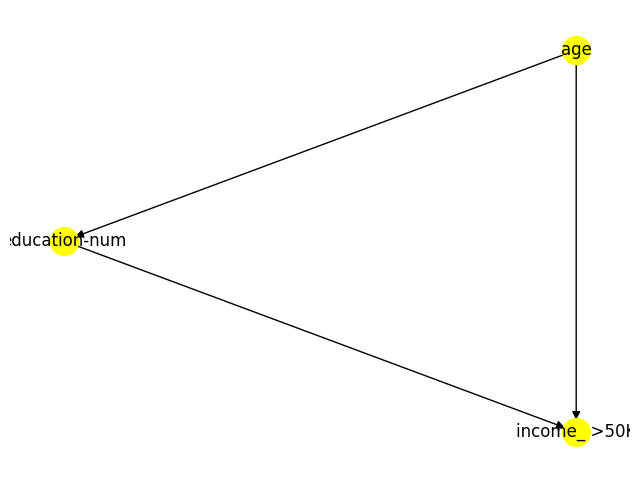

In [50]:
# View model
model.view_model()
#from IPython.display import Image, display
#display(Image(filename="causal_model.png"))

#### Generate estimand i.e. recipe for calculating causal effect

In [51]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                       
────────────────(Expectation(income_ >50K|age))
d[education-num]                               
Estimand assumption 1, Unconfoundedness: If U→{education-num} and U→income_ >50K then P(income_ >50K|education-num,age,U) = P(income_ >50K|education-num,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Compute causal effect using metaleaner

In [52]:
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)


metalearner_estimate = model.estimate_effect(identified_estimand_experiment,
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ValueError: Found unknown categories [0] in column 0 during transform

(array([6.700e+01, 0.000e+00, 0.000e+00, 0.000e+00, 4.805e+03, 1.650e+03,
        1.707e+03, 5.660e+02, 1.104e+03, 3.535e+03, 6.367e+03, 6.274e+03,
        4.434e+03, 1.469e+03, 1.780e+02, 2.560e+02, 0.000e+00, 1.430e+02,
        0.000e+00, 6.000e+00]),
 array([-0.15944615, -0.12383815, -0.08823015, -0.05262214, -0.01701414,
         0.01859387,  0.05420187,  0.08980987,  0.12541788,  0.16102588,
         0.19663389,  0.23224189,  0.26784989,  0.3034579 ,  0.3390659 ,
         0.37467391,  0.41028191,  0.44588991,  0.48149792,  0.51710592,
         0.55271392]),
 <BarContainer object of 20 artists>)

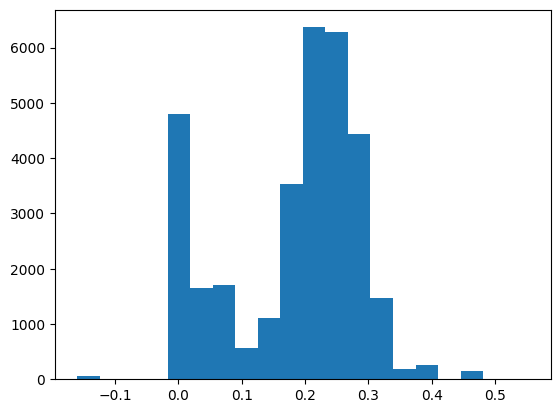

In [44]:
# print histogram of causal effects for each sample
plt.hist(metalearner_estimate.cate_estimates,bins=20)